# Introduction

In this notebook we are going to train model to classify 15 thoracic diseases including COVID-19. We will use InceptionV3 with pretrained Imagenet weights to train our model.

In [1]:
# Loading libraries

# os and file handling
import os
import glob
from tqdm import tqdm
from pathlib import Path

# Dataframe and matrix operation
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix

# Image 
import cv2
from PIL import Image, ImageFile
from skimage.transform import resize
from imgaug import augmenters as iaa

# Deep Learning
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.models import *
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

os.listdir('../input/')

['covid19', 'data']

# Data Preprocessing

## Loading Data

In [2]:
# .csv files
labels = pd.read_csv('../input/data/Data_Entry_2017.csv')
bbox_df = pd.read_csv('../input/data/BBox_List_2017.csv')

# .txt files
train_val = pd.read_csv('../input/data/train_val_list.txt')
test = pd.read_csv('../input/data/test_list.txt')

In [3]:
all_image_paths = {os.path.basename(x): x for x in 
                   glob.glob(os.path.join('..', 'input/data', 'images*', '*', '*.png'))}

In [4]:
labels['Paths'] = labels['Image Index'].map(all_image_paths.get)

In [5]:
labels

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,Paths
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,../input/data/images_001/images/00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,../input/data/images_001/images/00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,../input/data/images_001/images/00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,../input/data/images_001/images/00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,../input/data/images_001/images/00000003_000.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN,../input/data/images_012/images/00030801_001.png
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN,../input/data/images_012/images/00030802_000.png
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN,../input/data/images_012/images/00030803_000.png
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN,../input/data/images_012/images/00030804_000.png


## Preparing Covid Data

In [6]:
covid_image_paths = {os.path.basename(x): x for x in
                     glob.glob(os.path.join('..', 'input/covid19/', 'COVID', '*'))}

covid_image_paths = dict(sorted(covid_image_paths.items()))

In [7]:
len(covid_image_paths)

586

In [8]:
covid_data = []
count = int("30806")
for img in covid_image_paths:
    covid_data.append((img, "Covid", count))
    count += 1
    
len(covid_data)

586

In [9]:
covid_data = pd.DataFrame(covid_data, columns=['Image Index', 'Finding Labels', 'Patient ID'])

covid_data['Paths'] = covid_data['Image Index'].map(covid_image_paths.get)
covid_data

,Image Index,Finding Labels,Patient ID,Paths
0,00030806_000.png,Covid,30806,../input/covid19/COVID/00030806_000.png
1,00030807_000.png,Covid,30807,../input/covid19/COVID/00030807_000.png
2,00030808_000.png,Covid,30808,../input/covid19/COVID/00030808_000.png
3,00030809_000.png,Covid,30809,../input/covid19/COVID/00030809_000.png
4,00030810_000.png,Covid,30810,../input/covid19/COVID/00030810_000.png
...,...,...,...,...
581,00031387_000.png,Covid,31387,../input/covid19/COVID/00031387_000.png
582,00031388_000.png,Covid,31388,../input/covid19/COVID/00031388_000.png
583,00031389_000.png,Covid,31389,../input/covid19/COVID/00031389_000.png
584,00031390_000.png,Covid,31390,../input/covid19/COVID/00031390_000.png


In [10]:
covid_binarize = ['Covid']

for covid in tqdm(covid_binarize):
    covid_data[covid] = covid_data['Finding Labels'].map(lambda result: 1 if covid in result else 0)

100%|██████████| 1/1 [00:00<00:00, 415.61it/s]


In [11]:
labels = labels.append(covid_data) 

In [12]:
len(labels)

112706

## Preprocessing Labels: Binarization

In [13]:
# Disease Names / Class Labels 

disease_labels = ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'Covid']

In [14]:
# Binarizas Each Disease Class in their own column

for diseases in tqdm(disease_labels):
    labels[diseases] = labels['Finding Labels'].map(lambda result: 1 if diseases in result else 0)

print(f'There are {labels.shape[0]} and {labels.shape[1]} columns in this data frame after binarization.')


100%|██████████| 15/15 [00:01<00:00, 13.40it/s]

There are 112706 and 28 columns in this data frame after binarization.


In [15]:
labels = labels.drop(['Finding Labels', 'Follow-up #', 'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width', 'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'], axis = 1)

print(f"The new labels data frame consists of important columns. There are {labels.shape[0]} rows and {labels.shape[1]} columns in new labels data frame.")

The new labels data frame consists of important columns. There are 112706 rows and 18 columns in new labels data frame.


In [16]:
labels

,Image Index,Patient ID,Paths,Covid,Atelectasis,Consolidation,Infiltration,Pneumothorax,Edema,Emphysema,Fibrosis,Effusion,Pneumonia,Pleural_Thickening,Cardiomegaly,Nodule,Mass,Hernia
0,00000001_000.png,1,../input/data/images_001/images/00000001_000.png,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,00000001_001.png,1,../input/data/images_001/images/00000001_001.png,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
2,00000001_002.png,1,../input/data/images_001/images/00000001_002.png,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
3,00000002_000.png,2,../input/data/images_001/images/00000002_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00000003_000.png,3,../input/data/images_001/images/00000003_000.png,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,00031387_000.png,31387,../input/covid19/COVID/00031387_000.png,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
582,00031388_000.png,31388,../input/covid19/COVID/00031388_000.png,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
583,00031389_000.png,31389,../input/covid19/COVID/00031389_000.png,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
584,00031390_000.png,31390,../input/covid19/COVID/00031390_000.png,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
class_counts = labels.sum().drop(['Image Index', 'Patient ID', 'Paths'])

for column in class_counts.keys():
    print(f"The class {column} has {labels[column].sum()} samples")

The class Covid has 586 samples
The class Atelectasis has 11559 samples
The class Consolidation has 4667 samples
The class Infiltration has 19894 samples
The class Pneumothorax has 5302 samples
The class Edema has 2303 samples
The class Emphysema has 2516 samples
The class Fibrosis has 1686 samples
The class Effusion has 13317 samples
The class Pneumonia has 1431 samples
The class Pleural_Thickening has 3385 samples
The class Cardiomegaly has 2776 samples
The class Nodule has 6331 samples
The class Mass has 5782 samples
The class Hernia has 227 samples


## Splitting Data


## Patient Overlap

In [18]:
print(f"The total patient ids are {labels['Patient ID'].count()}, from those the unique ids are {labels['Patient ID'].value_counts().shape[0]} ")

The total patient ids are 112706, from those the unique ids are 31391 


In [19]:
patients = np.unique(labels['Patient ID'])

### Splitting for unique patients

In [20]:
# Train-Validation-Test Split 

train_patient, test_patient = train_test_split(patients,
                                   test_size = 0.20,
                                   random_state = 2020,
                                    shuffle= True)

train_patient, validation_patient = train_test_split(train_patient, 
                                    test_size = 0.15,
                                    random_state = 2020,
                                    shuffle = True)

## Splitting in Train, Validation and Test sets

In [21]:
print('Number of unique patients in Train dataset : ',len(train_patient))
train_df = labels[labels['Patient ID'].isin(train_patient)]
print('Training Dataframe   : ', train_df.shape[0],' images')

print('Number of unique patients in Validation dataset: ',len(validation_patient))
validation_df = labels[labels['Patient ID'].isin(validation_patient)]
print('Training Dataframe   : ', validation_df.shape[0],' images')

print('Number of unique patients in Test dataset: ',len(test_patient))
test_df = labels[labels['Patient ID'].isin(test_patient)]
print('Training Dataframe   : ', test_df.shape[0],' images')

Number of unique patients in Train dataset :  21345
Training Dataframe   :  75494  images
Number of unique patients in Validation dataset:  3767
Training Dataframe   :  14249  images
Number of unique patients in Test dataset:  6279
Training Dataframe   :  22963  images


In [22]:
print('Number of Diseases in each Class - Training')
for i in disease_labels:
    print(f"The class {i} has {train_df[i].sum()} samples.")

print('\n')

print('Number of Diseases in each Class - Validation')
for i in disease_labels:
    print(f"The class {i} has {validation_df[i].sum()} samples.")
    
print('\n')

print('Number of Disease in each class - Test')
for i in disease_labels:
    print(f"The class {i} has {test_df[i].sum()} samples.")

Number of Diseases in each Class - Training
The class Atelectasis has 7822 samples.
The class Consolidation has 3131 samples.
The class Infiltration has 13175 samples.
The class Pneumothorax has 3470 samples.
The class Edema has 1555 samples.
The class Emphysema has 1768 samples.
The class Fibrosis has 1100 samples.
The class Effusion has 8924 samples.
The class Pneumonia has 937 samples.
The class Pleural_Thickening has 2223 samples.
The class Cardiomegaly has 1835 samples.
The class Nodule has 4084 samples.
The class Mass has 3842 samples.
The class Hernia has 159 samples.
The class Covid has 401 samples.


Number of Diseases in each Class - Validation
The class Atelectasis has 1421 samples.
The class Consolidation has 560 samples.
The class Infiltration has 2629 samples.
The class Pneumothorax has 744 samples.
The class Edema has 322 samples.
The class Emphysema has 299 samples.
The class Fibrosis has 210 samples.
The class Effusion has 1598 samples.
The class Pneumonia has 184 samp

# Keras Data Generator


In [23]:
# Augmentations

augmenter = iaa.Sequential(
    [
        iaa.Fliplr(0.5),
    ],
    random_order=True,
)

In [24]:
# Custom generator

class AugmentedImageSequence(Sequence):

    def __init__(self, dataset_csv_file, class_names, batch_size=32,
                 target_size=(224, 224), augmenter=None, verbose=0, steps=None,
                 shuffle_on_epoch_end=True, random_state=1):
       
        self.dataset_df = dataset_csv_file
        self.batch_size = batch_size
        self.target_size = target_size
        self.augmenter = augmenter
        self.verbose = verbose
        self.shuffle = shuffle_on_epoch_end
        self.random_state = random_state
        self.class_names = class_names
        self.prepare_dataset()
        if steps is None:
            self.steps = int(np.ceil(len(self.x_path) / float(self.batch_size)))
        else:
            self.steps = int(steps)

    def __bool__(self):
        return True

    def __len__(self):
        return self.steps

    def __getitem__(self, idx):
        batch_x_path = self.x_path[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = np.asarray([self.load_image(x_path) for x_path in batch_x_path])
        batch_x = self.transform_batch_images(batch_x)
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_y

    def load_image(self, image_file):
        image = Image.open(image_file)
        image_array = np.asarray(image.convert("RGB"))
        image_array = image_array / 255.
        image_array = resize(image_array, self.target_size)
        return image_array

    def transform_batch_images(self, batch_x):
        if self.augmenter is not None:
            batch_x = self.augmenter.augment_images(batch_x)
        imagenet_mean = np.array([0.485, 0.456, 0.406])
        imagenet_std = np.array([0.229, 0.224, 0.225])
        batch_x = (batch_x - imagenet_mean) / imagenet_std
        return batch_x

    def get_y_true(self):
       
        if self.shuffle:
            raise ValueError("""
            You're trying run get_y_true() when generator option 'shuffle_on_epoch_end' is True.
            """)
        return self.y[:self.steps*self.batch_size, :]

    def prepare_dataset(self):
        df = self.dataset_df.sample(frac=1., random_state=self.random_state)
        self.x_path, self.y = df["Paths"].to_numpy(), df[self.class_names].to_numpy()

    def on_epoch_end(self):
        if self.shuffle:
            self.random_state += 1
            self.prepare_dataset()

In [25]:
train_sequence = AugmentedImageSequence(
            dataset_csv_file=train_df,
            class_names=disease_labels,
            batch_size=32,
            target_size=(224, 224),
            augmenter=augmenter,
            steps=train_df.shape[0]/32,
        )

validation_sequence = AugmentedImageSequence(
            dataset_csv_file=validation_df,
            class_names=disease_labels,
            batch_size=32,
            target_size=(224, 224),
            augmenter=augmenter,
            steps=validation_df.shape[0]/32,
            shuffle_on_epoch_end=False,
        )

test_sequence = AugmentedImageSequence(
    dataset_csv_file=test_df,
    class_names=disease_labels,
    batch_size=32,
    target_size=(224, 224),
    augmenter=None,
    steps=test_df.shape[0]/32,
    shuffle_on_epoch_end=False,
)

# Class Weighting


## Method 1

In [26]:
def get_sample_counts(dataset, class_names):
    
    df = dataset
    total_count = df.shape[0]
    labels = df[class_names].to_numpy()
    positive_counts = np.sum(labels, axis=0)
    class_positive_counts = dict(zip(class_names, positive_counts))
    return total_count, class_positive_counts

In [27]:
train_counts, train_pos_counts = get_sample_counts(train_df, disease_labels)

In [28]:
def get_class_weights(total_counts, class_positive_counts, multiply):
    
    def get_single_class_weight(pos_counts, total_counts):
        denominator = (total_counts - pos_counts) * multiply + pos_counts
        return {
            0: pos_counts / denominator,
            1: (denominator - pos_counts) / denominator,
        }

    class_names = list(class_positive_counts.keys())
    label_counts = np.array(list(class_positive_counts.values()))
    class_weights = []
    for i, class_name in enumerate(class_names):
        class_weights.append(get_single_class_weight(label_counts[i], total_counts))

    return class_weights


In [29]:
class_weights = get_class_weights(
            train_counts,
            train_pos_counts,
            multiply=1,
        )

## Method 2

In [30]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def compute_class_freqs(labels):
    
    positive_frequencies = np.array(np.sum(labels == 1,axis=0) / labels.shape[0])
    negative_frequencies = np.array(np.sum(labels == 0,axis=0) / labels.shape[0])

    ### END CODE HERE ###
    return positive_frequencies, negative_frequencies

In [31]:
train_labels = train_df.drop(['Image Index', 'Patient ID', 'Paths'], axis = 1) 

In [32]:
freq_pos, freq_neg = compute_class_freqs(train_labels)

In [33]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights

In [34]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    
    def weighted_loss(y_true, y_pred):
        
        # initialize loss to zero
        loss = 0.0

        for i in range(len(pos_weights)):
            # for each class, add average weighted loss for that class 
            loss += K.mean((-1 * pos_weights[i] * y_true[:,i]*K.log(y_pred[:,i]+epsilon)) + (- 1 * neg_weights[i]*(1-y_true[:,i])*K.log(1-y_pred[:,i]+epsilon))) #complete this line
        return loss
    
    return weighted_loss

# Callbacks

In [35]:
# Saves weights

weight_path = "/kaggle/working/Covid_Inception.h5"


cp_callback = ModelCheckpoint(filepath = weight_path, 
                              verbose=1,
                              monitor='val_loss',
                              save_best_only = True,
                              save_weights_only=True)

reduced_lr = ReduceLROnPlateau(monitor='val_loss',
                               factor=.1,
                               patience=1,
                               verbose=1,
                               mode='min',
                               min_lr=1e-8)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5)

callbacks_list = [cp_callback, early, reduced_lr]

# Model: Inception

In [36]:
# Defining Hyperparameters

EPOCHS = 30
batch_size = 32
train_steps = int(len(train_df) / batch_size / 10)
validation_steps = int(len(validation_df) / batch_size / 10)

# Compilie
OPTIMIZER = Adam(learning_rate=0.001)

In [37]:
# Model: Inception

base_model = InceptionV3(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')        # base pre-trained model

multi_disease_model = base_model.output
multi_disease_model = GlobalAveragePooling2D()(multi_disease_model)    # global spatial average pooling layer
multi_disease_model = Dense(len(disease_labels), activation = 'sigmoid')(multi_disease_model)    # logistic layer
multi_disease_model = Model(inputs = base_model.input, outputs = multi_disease_model)

for layers in base_model.layers:
    layers.trainable = False
    
multi_disease_model.summary()

87916544/87910968 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_____________________________

# Compiling

In [38]:
for layers in base_model.layers:
    layers.trainable = False

In [39]:
# Compiling model

multi_disease_model.compile(optimizer = OPTIMIZER,
                            loss = get_weighted_loss(pos_weights, neg_weights), metrics=['accuracy'])

# Training

In [40]:
# Training Model

history = multi_disease_model.fit_generator(generator=train_sequence,
                                  steps_per_epoch = train_steps,
                                  validation_data = validation_sequence,
                                  validation_steps = validation_steps ,
                                  epochs = EPOCHS,
                                  callbacks = callbacks_list,
                                  shuffle = False)

Epoch 1/30
235/235 [==============================] - ETA: 0s - loss: 0.6721 - accuracy: 0.5124
Epoch 00001: val_loss improved from inf to 0.65972, saving model to /kaggle/working/Covid_Inception.h5
235/235 [==============================] - 1259s 5s/step - loss: 0.6721 - accuracy: 0.5124 - val_loss: 0.6597 - val_accuracy: 0.2628 - lr: 0.0010
Epoch 2/30
235/235 [==============================] - ETA: 0s - loss: 0.6486 - accuracy: 0.4859
Epoch 00002: val_loss improved from 0.65972 to 0.65842, saving model to /kaggle/working/Covid_Inception.h5
235/235 [==============================] - 1292s 5s/step - loss: 0.6486 - accuracy: 0.4859 - val_loss: 0.6584 - val_accuracy: 0.1307 - lr: 0.0010
Epoch 3/30
235/235 [==============================] - ETA: 0s - loss: 0.6333 - accuracy: 0.4638
Epoch 00003: val_loss improved from 0.65842 to 0.65372, saving model to /kaggle/working/Covid_Inception.h5
235/235 [==============================] - 1282s 5s/step - loss: 0.6333 - accuracy: 0.4638 - val_loss: 

# Evaluation

## Accuracy & Loss Graphs

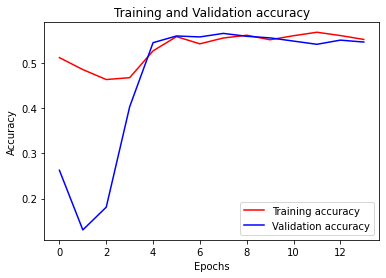

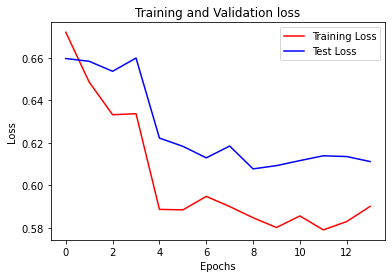

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Test Loss')
plt.title('Training and Validation loss')
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
# plt.savefig('/kaggle/working/train_test_loss_vgg_xception.png', dpi=100)
plt.show()

## Confusion Matrix

In [42]:
#Confution Matrix and Classification Report

Y_pred = multi_disease_model.predict_generator(test_sequence, steps = len(test_sequence))
y_pred = np.argmax(Y_pred, axis=1)


y = test_sequence.get_y_true()
y = np.argmax(y, axis=1)


print('Confusion Matrix')

print(confusion_matrix(y, y_pred))

Confusion Matrix
[[11880     0  1134     0     0     2    15  1075     0    72     2   263
      0     0    32]
 [  556     0    37     0     0     1     0   149     0     1     0     2
      0     0     0]
 [ 2509     0   235     0     1     1     3   402     0    16     0    35
      0     0    10]
 [  595     0    39     0     0     0     3   117     0     6     0     8
      0     0     1]
 [  147     0    12     0     0     0     0    49     0     1     0     0
      0     0     0]
 [  200     0    10     0     0     0     0    20     0     3     0     3
      0     0     0]
 [  169     0     6     0     0     0     1    37     0     3     0     9
      1     0     0]
 [  911     0    22     0     0     0     0   273     0     7     0    10
      0     0     0]
 [   71     0     5     0     0     0     0     7     0     1     0     0
      0     0     0]
 [  222     0    14     0     0     0     0    35     0     4     0     6
      0     0     1]
 [  213     0     6     0     0  

NameError: name 'ax' is not defined

<Figure size 432x288 with 0 Axes>

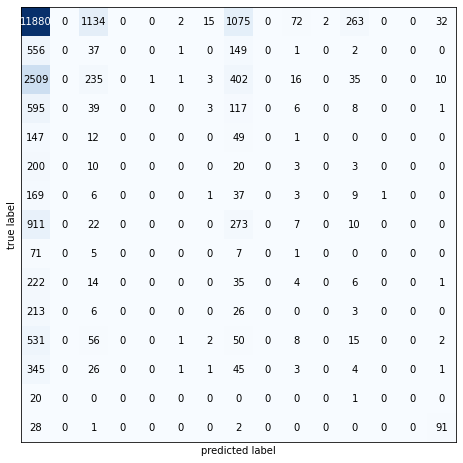

In [43]:
cm  = confusion_matrix(y, y_pred)
plt.figure()

plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Blues)
sns.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="g")

plt.xticks(range(15), ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'Covid'], fontsize=16)
plt.yticks(range(15), ['Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax', 'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia', 'Pleural_Thickening',
'Cardiomegaly', 'Nodule', 'Mass', 'Hernia', 'Covid'], fontsize=16)

plt.show()